Put netcdf files of the same case to folder so that they can be read in together.
And plot some slices.

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
import xrft

### Convert NetCDF
(Now that every case has been converted this is no longer needed.)

In [6]:
time = [0, 40, 80, 110, 120, 130, 150, 160, 170]
# filename = '../../multilayer/JFM2023/compilation/' + 'fieldsample_Cvalid1_t%g.nc' %t 
for i, t in enumerate(time):
    filename = '../../multilayer/JFM2023/compilation/' + 'fieldsample_C5_t%g.nc' %t
    ds = xr.open_dataset(filename, engine='h5netcdf')
    ds = ds.expand_dims({'t':np.array([ds.attrs['t']])})
    compression_settings = {
        'zlib': True,          # Enable zlib compression
        'complevel': 8,        # Set the compression level (1-9)
        'shuffle': True        # Enable the shuffle filter
    }
    encoding = {var: compression_settings for var in ds.data_vars}
    folder_path = '../../multilayer/JFM2023/compilation/C5/'
    os.makedirs(folder_path, exist_ok=True)
    ds.to_netcdf(folder_path + 'field%g.nc' %t, encoding=encoding, engine='netcdf4') 



In [2]:
# Read in
ds = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/Cvalid1/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds.attrs['t']
ds = ds.chunk({'x':-1, 'y':-1})
ds = ds.sortby('t')


### Plot slices

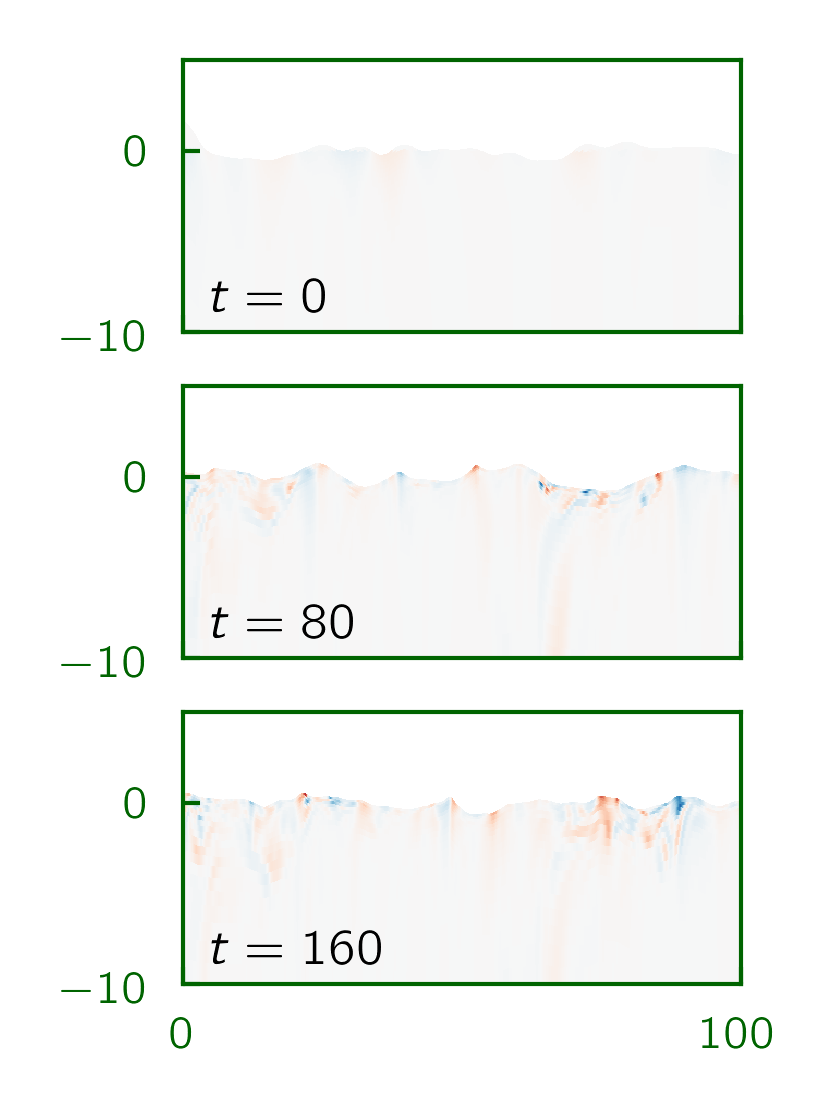

In [4]:
fig, axes = plt.subplots (3, 1, figsize=[1.2,2], sharex=True); ax = plt.gca()
c = 'darkgreen'
for i,t in enumerate((0,80,160)):    
    vort2d = ds.omegaz.sel(y=0, t=t, method='nearest')
    vort2d.plot(ax=axes[i], y='z', xlim=[0,100], ylim=[-10,5], cmap='RdBu_r',
                vmax=0.4, vmin=-0.4, add_colorbar=False) # cbar_kwargs={'label':r'$\omega_x$'}
    axes[i].set_yticks([-10,0]); axes[i].set_xticks([0, 100])
    axes[i].set(xlabel=None, ylabel=None, title=None)
    axes[i].spines['bottom'].set_color(c)
    axes[i].spines['top'].set_color(c)
    axes[i].spines['right'].set_color(c)
    axes[i].spines['left'].set_color(c)
    axes[i].annotate(r'$t=%g$' %t, (5,-9), fontsize=6)   

axes[0].tick_params(axis='both', colors=c)
axes[1].tick_params(axis='both', colors=c)
axes[2].tick_params(axis='both', colors=c)

plt.savefig('../figures/multilayer-diss/vort_side_' + ds.caselabel + '.tiff', bbox_inches='tight')


Average depth: -7.29318


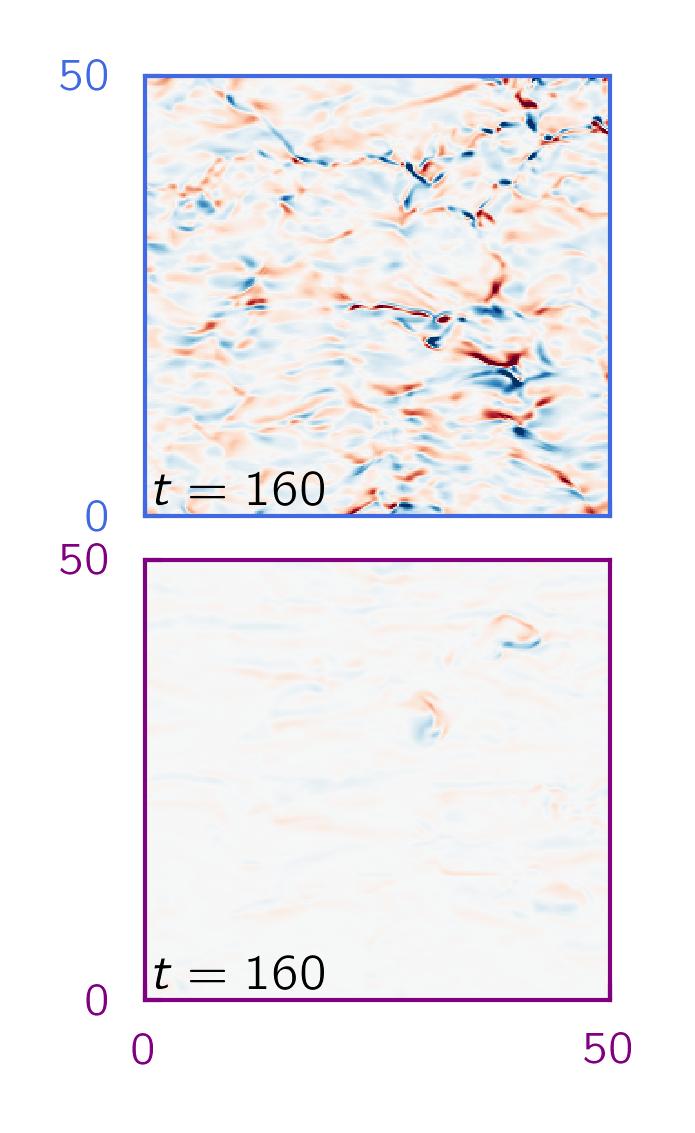

In [5]:
fig, axes = plt.subplots (2, 1, figsize=[1,2], sharex=True); ax = plt.gca()

depth = -7
zmean = ds.z.mean(dim=['x','y','t'])
NLAYER = zmean.sizes['zl']
LAYER = np.abs(zmean.values - depth).argmin()

vort2d = ds.omegaz.sel(zl=LAYER,t=160)
print('Average depth: %g' %(np.average(vort2d.z)))
ax = axes[1]
vort2d.plot(ax=ax, x='x', vmax=0.4, vmin=-0.4, cmap='RdBu_r', add_colorbar=False, xincrease=True, yincrease=True)
ax.set(xlabel=None, ylabel=None, title=None)
ax.set_xlim([0,50]); ax.set_xticks([-0,50])
ax.set_yticks([0,50]); ax.set_ylim([0,50])
c = 'purple'
ax.tick_params(axis='both', colors=c)
ax.tick_params(axis='both', colors=c)
ax.tick_params(axis='both', colors=c)
ax.spines['bottom'].set_color(c)
ax.spines['top'].set_color(c)
ax.spines['right'].set_color(c)
ax.spines['left'].set_color(c)
ax.annotate('$t=%g$' %160, (1,1), fontsize=6)

vort2d = ds.omegaz.sel(zl=NLAYER-1,t=160)
ax = axes[0]
vort2d.plot(ax=ax, x='x', vmax=0.4, vmin=-0.4, cmap='RdBu_r', add_colorbar=False, xincrease=True, yincrease=True)
ax.set(xlabel=None, ylabel=None, title=None)
ax.set_xlim([0,50]); ax.set_xticks([-0,50])
ax.set_yticks([0,50]); ax.set_ylim([0,50])
c = 'royalblue'
ax.tick_params(axis='both', colors=c)
ax.tick_params(axis='both', colors=c)
ax.tick_params(axis='both', colors=c)
ax.spines['bottom'].set_color(c)
ax.spines['top'].set_color(c)
ax.spines['right'].set_color(c)
ax.spines['left'].set_color(c)
ax.annotate('$t=%g$' %160, (1,1), fontsize=6)

# axes[0].get_xaxis().set_visible(False)
# axes[0].get_yaxis().set_visible(False)
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.1)
plt.savefig('../figures/multilayer-diss/vort_top_' + ds.caselabel + '.tiff', bbox_inches='tight')

[Text(0.5, 0, ''), Text(0, 0.5, ''), Text(0.5, 1.0, '')]

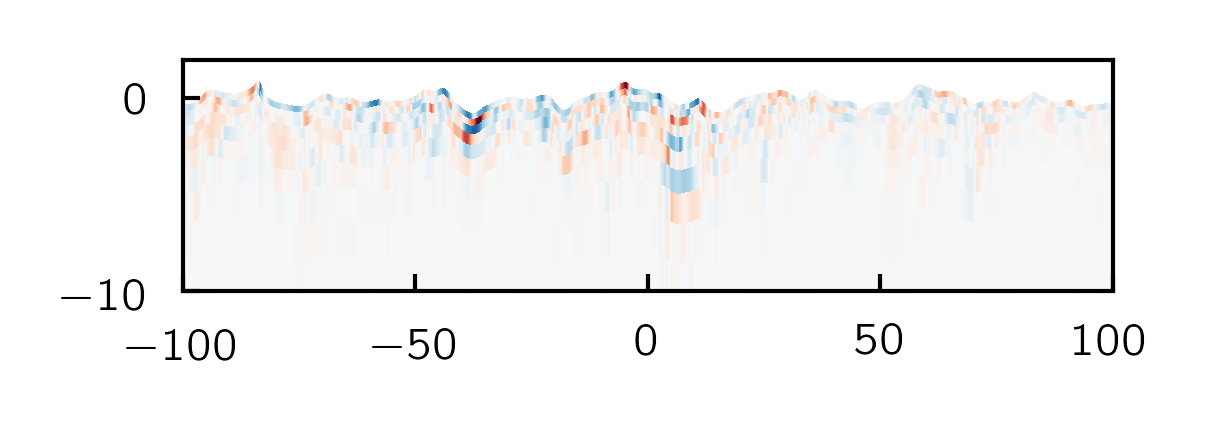

In [45]:
plt.figure(figsize=[2,0.5]); ax=plt.gca()
ds.omegax.sel(y=0,t=160,method='nearest').plot(x='x',y='z',vmax=0.5,vmin=-0.5,
                                               add_colorbar=False,cmap='RdBu_r')
ax.set_ylim([-10,2])
ax.set(xlabel=None, ylabel=None, title=None)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

def spectrum_1D (field):
    # Step 1: Generate or load a 2D field (for example, a synthetic field)
    # For demonstration, let's create a 2D Gaussian random field
    size = 1024

    # Step 2: Compute the 2D Fourier Transform
    ft_field = fft2(field)
    ft_field_shifted = fftshift(ft_field)  # Shift the zero frequency component to the center

    # Step 3: Compute the 2D Power Spectrum
    power_spectrum_2d = np.abs(ft_field_shifted)**2

    # Step 4: Compute the 1D Power Spectrum by radially averaging the 2D Power Spectrum
    # Create an array of the same shape as the field containing the radial distances
    y, x = np.indices((size, size))
    center = (size // 2, size // 2)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Bin the power spectrum based on radial distance
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), power_spectrum_2d.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / nr
    
    return radial_profile


In [161]:
window = 'hann'
nfactor = 2
truncate = True
detrend = None
window_correction = True
Fux = xrft.isotropic_power_spectrum(ds.ux.sel(zl=29).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                   truncate=truncate, detrend=detrend, window_correction=window_correction)
Fuy = xrft.isotropic_power_spectrum(ds.uy.sel(zl=29).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                   truncate=truncate, detrend=detrend, window_correction=window_correction)
Fuz = xrft.isotropic_power_spectrum(ds.uz.sel(zl=29).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                   truncate=truncate, detrend=detrend, window_correction=window_correction)
Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=29).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                   truncate=truncate, detrend=detrend, window_correction=window_correction)

[0.08       0.0844898  0.08897959 0.09346939 0.09795918 0.10244898
 0.10693878 0.11142857 0.11591837 0.12040816 0.12489796 0.12938776
 0.13387755 0.13836735 0.14285714 0.14734694 0.15183673 0.15632653
 0.16081633 0.16530612 0.16979592 0.17428571 0.17877551 0.18326531
 0.1877551  0.1922449  0.19673469 0.20122449 0.20571429 0.21020408
 0.21469388 0.21918367 0.22367347 0.22816327 0.23265306 0.23714286
 0.24163265 0.24612245 0.25061224 0.25510204 0.25959184 0.26408163
 0.26857143 0.27306122 0.27755102 0.28204082 0.28653061 0.29102041
 0.2955102  0.3       ]


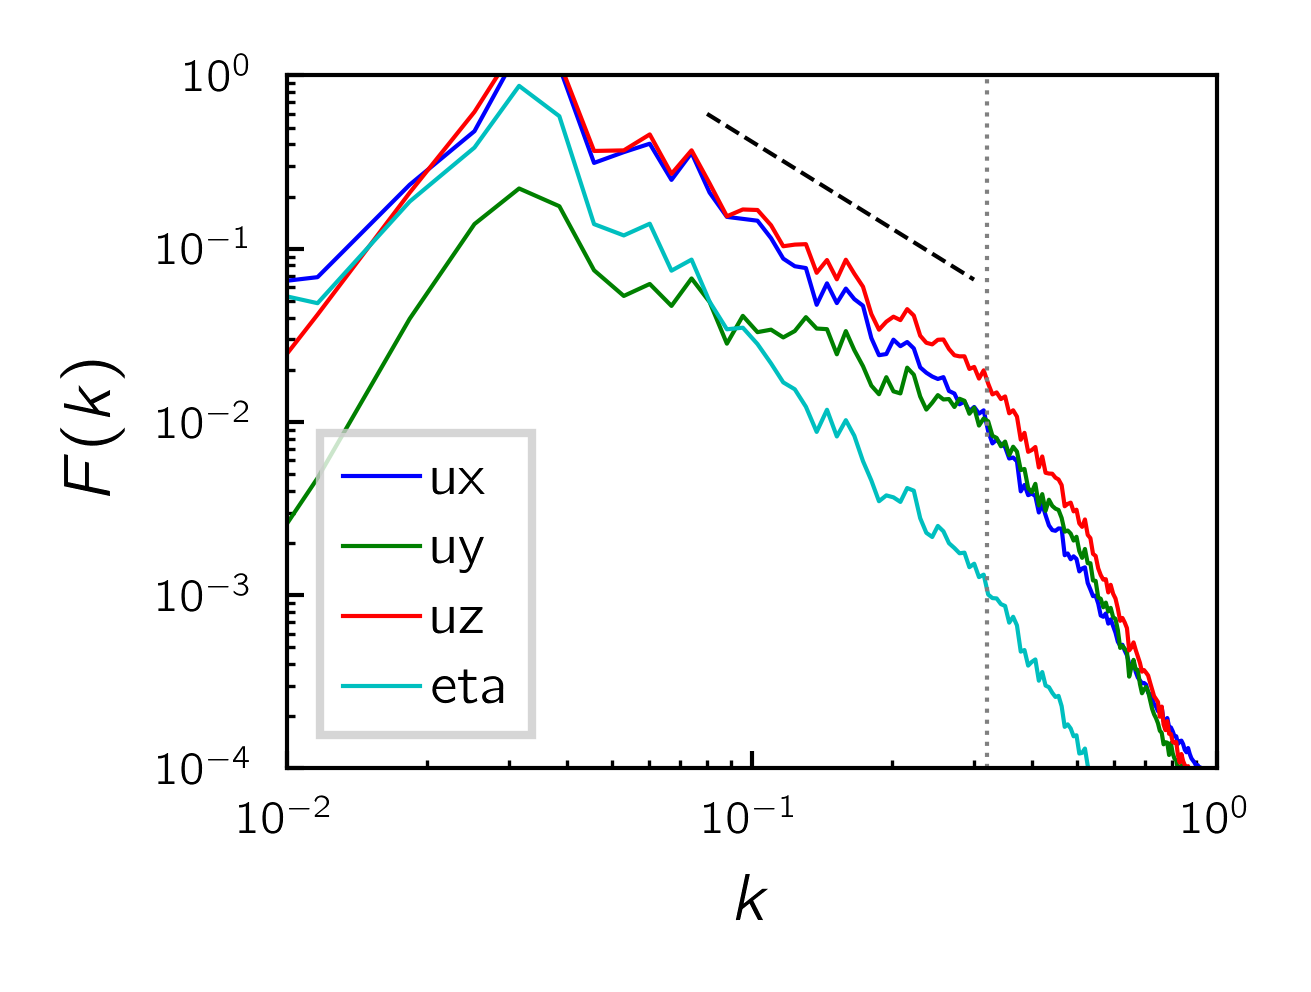

In [162]:
fig = plt.figure (figsize=[2,1.5])

Fux.plot(label='ux')
Fuy.plot(label='uy')
Fuz.plot(label='uz')
Feta.plot(label='eta')



plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-2),1])
plt.axvline(x=(1024/16)/200, linestyle=':', c='gray')
plt.legend()